# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree


# Load and prepare dataset

In [3]:
dataset = pd.read_csv("../data/titanic/titanic.csv")

In [4]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

In [6]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

In [8]:
X_train

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
331,1,45.500000,28.5000,1,56,2
733,2,23.000000,13.0000,1,-1,2
382,3,32.000000,7.9250,1,-1,2
704,3,26.000000,7.8542,1,-1,2
813,3,6.000000,31.2750,0,-1,2
...,...,...,...,...,...,...
106,3,21.000000,7.6500,0,-1,2
270,1,29.699118,31.0000,1,-1,2
860,3,41.000000,14.1083,1,-1,2
435,1,14.000000,120.0000,0,47,2


In [9]:
train_data = lgb.Dataset(data=X_train, label=y_train)
valid_data = lgb.Dataset(data=X_test, label=y_test)

# Train the model

In [10]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

In [11]:
lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data])

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.640939	valid_1's binary_logloss: 0.658567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.621711	valid_1's binary_logloss: 0.637865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's binary_logloss: 0.613448	valid_1's binary_logloss: 0.6286

In [12]:
lgbm_model.attr("num_classes")

In [13]:
lgbm_model._Booster__num_class

1

In [14]:
dir(lgbm_model)

['_Booster__attr',
 '_Booster__boost',
 '_Booster__get_eval_info',
 '_Booster__higher_better_inner_eval',
 '_Booster__init_predictor',
 '_Booster__inner_eval',
 '_Booster__inner_predict',
 '_Booster__inner_predict_buffer',
 '_Booster__is_predicted_cur_iter',
 '_Booster__name_inner_eval',
 '_Booster__need_reload_eval_info',
 '_Booster__num_class',
 '_Booster__num_dataset',
 '_Booster__num_inner_eval',
 '_Booster__set_objective_to_none',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_free_buffer',
 '_to_predictor',
 '_train_data_name',
 'add_valid',
 'attr',
 'best_iteration',
 'best_score',
 

In [15]:
lgbm_model._Booster__num_dataset

0

In [16]:
print(lgbm_model.model_to_string())

tree
version=v3
num_class=1
num_tree_per_iteration=1
label_index=0
max_feature_idx=5
objective=binary sigmoid:1
feature_names=Pclass Age Fare Sex_label Cabin_label Embarked_label
feature_infos=[1:3] [0.41999999999999998:80] [0:512.32920000000001] [0:1] [-1:146] [-1:2]
tree_sizes=1575 1474 1581 1575 1259 1365 1168 1379 1371 1483 1156 1274 1485 1365 1472 1472 1271 1269 1388 1482 1492 1373 1364 1397 1578 1159 1165 1165 1378 1381 1470 1167 1375 1158 1573 1263 1177 1052 1398 1394 1364 1389 1481 1499 1154 1369 1370 1158 1255 1468 1054 1281 1272 1370 1261 1382 1386 1175 1284 1264 1366 1400 1371 1500 1471 1051 1464 1388 1282 1500 1270 1286 1368 1368 1394 1385 1154 1477 1374 1269 1362 1357 1503 1395 1070 1362 1383 1478 1389 1160 1494 1263 1067 1500 1275 1276 1359 1497 1274 1361

Tree=0
num_leaves=14
num_cat=0
split_feature=3 0 2 0 5 2 2 2 2 2 2 2 2
split_gain=208.967 58.5517 19.6935 12.3178 5.44603 2.02377 1.55481 1.06321 0.854694 0.381343 0.336123 0.2809 0.208068
threshold=1.0000000180025095e-

In [17]:
lgbm_model.dump_model(num_iteration=1)

{'name': 'tree',
 'version': 'v3',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 5,
 'objective': 'binary sigmoid:1',
 'average_output': False,
 'feature_names': ['Pclass',
  'Age',
  'Fare',
  'Sex_label',
  'Cabin_label',
  'Embarked_label'],
 'monotone_constraints': [],
 'feature_infos': {'Pclass': {'min_value': 1, 'max_value': 3, 'values': []},
  'Age': {'min_value': 0.42, 'max_value': 80, 'values': []},
  'Fare': {'min_value': 0, 'max_value': 512.3292, 'values': []},
  'Sex_label': {'min_value': 0, 'max_value': 1, 'values': []},
  'Cabin_label': {'min_value': -1, 'max_value': 146, 'values': []},
  'Embarked_label': {'min_value': -1, 'max_value': 2, 'values': []}},
 'tree_info': [{'tree_index': 0,
   'num_leaves': 14,
   'num_cat': 0,
   'shrinkage': 0.193565,
   'tree_structure': {'split_index': 0,
    'split_feature': 3,
    'split_gain': 208.9669952392578,
    'threshold': 1.0000000180025095e-35,
    'decision_type': '<=',
    'default_lef

In [18]:
lgbm_model.dump_model(num_iteration=1)["objective"]

'binary sigmoid:1'

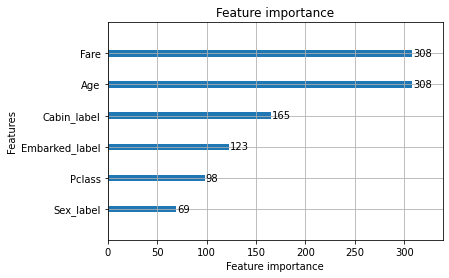

In [19]:
lgb.plot_importance(lgbm_model)

<Figure size 1440x1440 with 0 Axes>

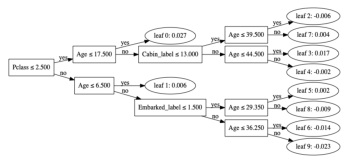

In [20]:
plt.figure(figsize=(20,20))
lgb.plot_tree(lgbm_model, tree_index=10)

In [21]:
features

['Pclass', 'Age', 'Fare', 'Sex_label', 'Cabin_label', 'Embarked_label']

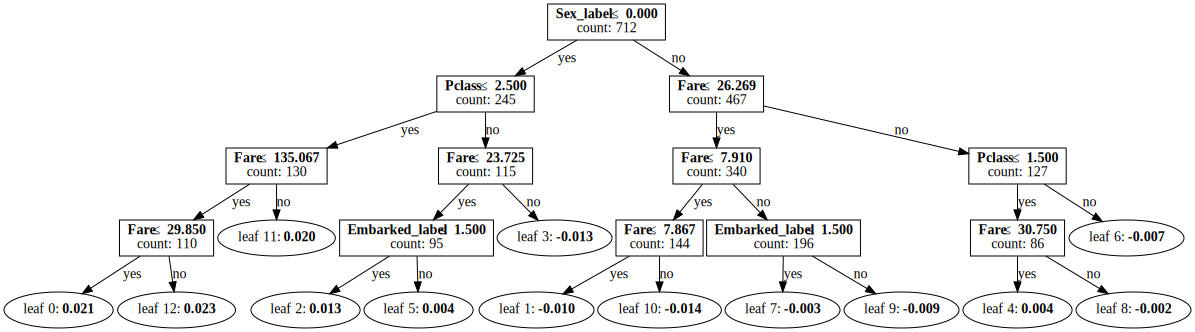

In [22]:
lgb.create_tree_digraph(lgbm_model, tree_index=1,  orientation = "vertical", show_info=['internal_count'])


## Model metadata interpretation

In [23]:
import json

In [24]:
tree_dump = lgbm_model.dump_model()["tree_info"][1]

In [25]:
def _get_nodes_info(node):
    tree_nodes = {}
    children_left = {}
    children_right = {}
    node_index = 0
    
    def _walk_tree(node, node_id):
        nonlocal node_index
        tree_nodes[node_id] = node
        if node.get("split_index") is None:
            children_left[node_id] = -1
            children_right[node_id] = -1
            return

        node_index += 1
        children_left[node_id] = node_index
        _walk_tree(node.get("left_child"), node_index)
        
        node_index += 1
        children_right[node_id] = node_index
        _walk_tree(node.get("right_child"), node_index)
        
    def _convert_dict_to_list(my_dict):
        my_list = [-1] * len(my_dict)
        for key, value in my_dict.items():
            my_list[key] = value
        return my_list
        
    _walk_tree(node, node_index)

    for node in tree_nodes.values():
        node.pop("left_child", None)
        node.pop("right_child", None)
        
    children_left_list = _convert_dict_to_list(children_left)
    children_right_list = _convert_dict_to_list(children_right)
    tree_node_list = _convert_dict_to_list(tree_nodes)
    
    return tree_node_list, children_left_list, children_right_list


In [26]:
tree_nodes, children_left, children_right = _get_nodes_info(tree_dump["tree_structure"])

In [27]:
print(children_left)
print(children_right)

[1, 2, 3, 4, -1, -1, -1, 8, 9, -1, -1, -1, 13, 14, 15, -1, -1, 18, -1, -1, 21, 22, -1, -1, -1]
[12, 7, 6, 5, -1, -1, -1, 11, 10, -1, -1, -1, 20, 17, 16, -1, -1, 19, -1, -1, 24, 23, -1, -1, -1]


In [28]:
tree_nodes[19]

{'leaf_index': 9,
 'leaf_value': -0.008689234807276692,
 'leaf_weight': 40.59755164384842,
 'leaf_count': 175}

In [29]:
tree_nodes[0]

{'split_index': 0,
 'split_feature': 3,
 'split_gain': 187.06399536132812,
 'threshold': 1.0000000180025095e-35,
 'decision_type': '<=',
 'default_left': True,
 'missing_type': 'None',
 'internal_value': 0,
 'internal_weight': 0,
 'internal_count': 712}

In [30]:
tree_nodes[19]

{'leaf_index': 9,
 'leaf_value': -0.008689234807276692,
 'leaf_weight': 40.59755164384842,
 'leaf_count': 175}

# dtreeviz clasification

## Save the model

In [44]:
# lgbm_model.save_model("../testing/dtreeviz/models/fixtures/lightgbm_model_classifier.txt")
# lgbm = lgb.Booster(model_file="../testing/dtreeviz/models/fixtures/lightgbm_model_classifier.txt")

In [45]:
light_dtree = ShadowLightGBMTree(lgbm_model, tree_index=1, x_data=X_train, y_data=y_train, feature_names=features, target_name=target, class_names=[0,1] )


## Visualizations

In [47]:
x = X_train[features].iloc[2]
x

Pclass             3.000
Age               32.000
Fare               7.925
Sex_label          1.000
Cabin_label       -1.000
Embarked_label     2.000
Name: 382, dtype: float64

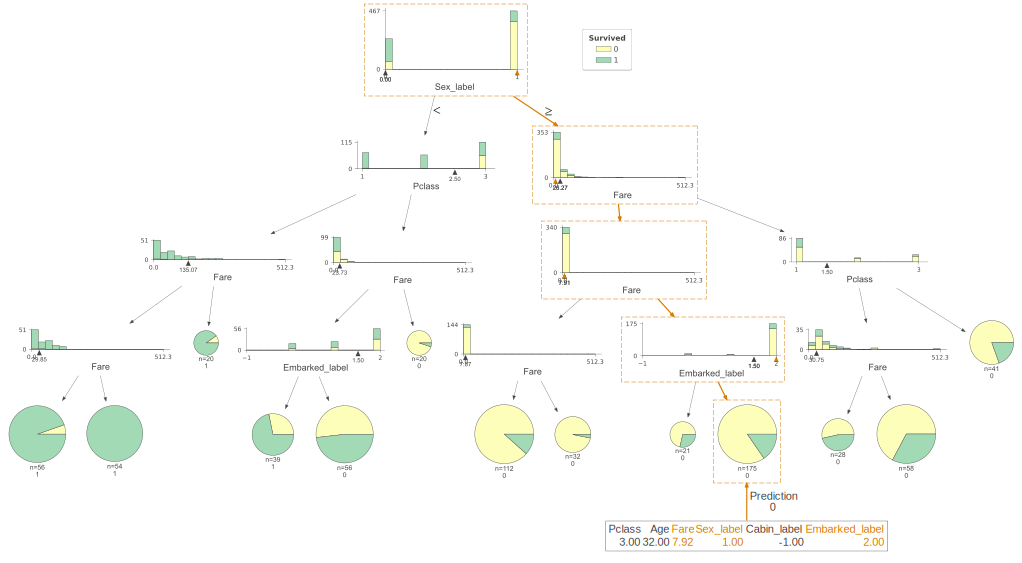

In [49]:
trees.dtreeviz(light_dtree, X=x, show_just_path=False)

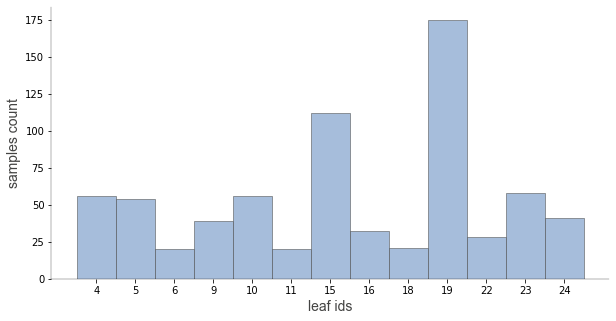

In [69]:
trees.viz_leaf_samples(light_dtree)

In [70]:
trees.viz_leaf_criterion(light_dtree)

VisualisationNotYetSupportedError: get_node_criterion() is not implemented for LightGBM yet